### Velocity auto-correlation

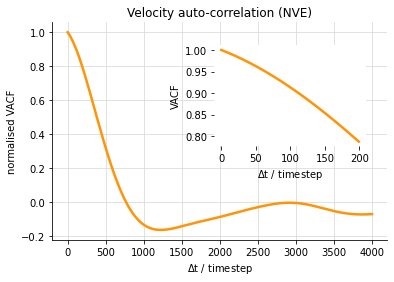

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lj_test.vacf import VACF
thermostat, thermostat_capital = 'nve', 'NVE'
vacf = VACF(f"/home/markjenei/polymerisation-coarse-graining/lj_test/files/lj_{thermostat}_vacf.out")
data = vacf.read_data()
ave_vacf = np.mean(data, axis=0)
ave_vacf /= ave_vacf[0]
timestep = 0.5e-3
t = np.arange(0, len(ave_vacf), 1)

fig, ax = plt.subplots(1, 1)
ax.plot(t, ave_vacf, lw=2.5, color="xkcd:tangerine")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#ax.spines["bottom"].set_color('xkcd:red')
ax.set_xlabel(r"$\Delta$t / timestep")
ax.set_ylabel("normalised VACF")
ax.set_title(f"Velocity auto-correlation ({thermostat_capital})")
ax.grid(color='xkcd:light grey')

left, bottom, width, height = [0.5, 0.45, 0.35, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.plot(t[:200], ave_vacf[:200], lw=2.5, color="xkcd:tangerine")
ax2.set_xlabel(r"$\Delta$t / timestep")
ax2.set_ylabel("VACF")

plt.savefig(f"lj_{thermostat}_vacf.png", bbox_inches='tight')

### Derived velocity and net force


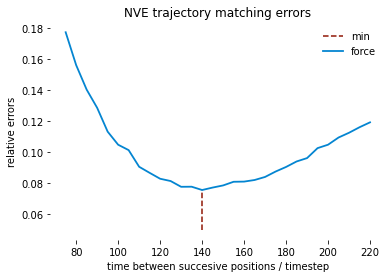

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lj_test.velocity_force_grain import VF_grain

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/files/lj_nve_dump.out"
vf = VF_grain(outfile_path=outfile, res=100, timestep=0.5)

for res in np.arange(75, 225, 5):
    vf.res = res
    vf.grain_velocity_force()

res = list(vf.a_derived_error.keys())
a_error = np.array(list(vf.a_derived_error.values()))
v_error = np.array(list(vf.v_derived_error.values()))
error = (v_error + a_error)/2
min_error_x = int(np.argwhere(error == np.min(error)))
min_a_x = int(np.argwhere(a_error == np.min(a_error)))

fig, ax = plt.subplots(1, 1)

#ax.plot(res, v_error, lw=1.8, label="velocity", color="xkcd:pale orange")
#ax.axvline(res[min_error_x], color="xkcd:greenish", ls='--')
ax.plot([res[np.argmin(a_error)], res[np.argmin(a_error)]], [0.05, np.min(a_error)], color="xkcd:brick red", ls='--', label='min')
ax.plot(res, a_error, lw=1.8, label="force", color="xkcd:cerulean")
#ax.plot(res, error, lw=1.8, label="combined", color="xkcd:greenish")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_title("NVE trajectory matching errors")
ax.set_ylabel("relative errors")
ax.set_xlabel("time between succesive positions / timestep")
ax.legend(frameon=False)

plt.savefig("nve_errors.png", bbox_inches="tight")


### Data processing

Reading data 3.2743325233459473 s
Preparing input 21.69 s


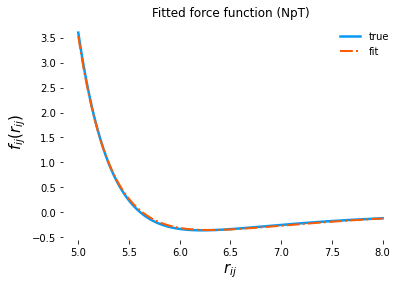

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lj_test.data_processing import DataProcessing

def basis_function(x, p):
    return np.sign(x) * np.abs(x) ** p

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/files/lj_trajectory_match_npt.out"
params = range(0, -15, -1)
steps = 20
output_timestep = 0.5

proc = DataProcessing(outfile_path=outfile, timestep=output_timestep*steps, cutoff=15,
                      basis=basis_function, basis_parameters=params,
                      steps_between_points=steps, steps_used_in_fit=500)
proc.prepare_training_data()
proc.regress(method='bayesian')

x = np.linspace(5, 8, 1000)
y = proc.predict(x)
y_ = 24 * 0.75 / x * (2 * (5/x) ** 12 - (5/x) ** 6)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y_, label='true', lw=2.5, color='xkcd:azure')
ax.plot(x, y, label='fit', ls='-.', lw=2., color='xkcd:bright orange')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_title(r"Fitted force function (NpT)")
ax.set_xlabel(r"$r_{ij}$", fontsize=15)
ax.set_ylabel(r"$f_{ij}(r_{ij})$", fontsize=15)
ax.legend(frameon=False)

#plt.savefig("lj_npt_fit.png", bbox_inches='tight')

In [75]:
def basis_function(x, p):
    return np.sign(x) * np.abs(x) ** p

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/files/lj_trajectory_match_npt.out"
params = range(0, -15, -1)
steps = [10, 15, 20, 25, 30]
x = np.linspace(5, 8, 1000)
y_dict = {}
y_ = 24 * 0.75 / x * (2 * (5/x) ** 12 - (5/x) ** 6)

for step in steps:
    proc = DataProcessing(outfile_path=outfile, timestep=0.5*step, cutoff=15,
                          basis=basis_function, basis_parameters=params, steps_between_points=step, steps_used_in_fit=500)
    proc.prepare_training_data()
    proc.regress(method='bayesian')
    y_dict[step] = proc.predict(x)

fig, ax = plt.subplots()
for step in steps:
    ax.plot(x, y_dict[step] - y_, label=r"$\Delta$t = "+f"{step*0.5} fs", ls='--')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_title(r"Deviation from true force (NpT)")
ax.set_xlabel(r"$r_{ij}$", fontsize=15)
ax.set_ylabel(r"$\Delta F_{ij}$", fontsize=15)
ax.legend(frameon=False)
#plt.savefig("lj_npt_fit_timestep.png", bbox_inches='tight')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from lj_test.data_processing import DataProcessing

def basis_function(x, p):
    return np.sign(x) * np.abs(x) ** p

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/files/lj_trajectory_match_nve.out"
params = range(0, -15, -1)
steps = 30

proc = DataProcessing(outfile_path=outfile, timestep=0.5*steps, cutoff=15,
                      basis=basis_function, basis_parameters=params,
                      steps_between_points=steps, steps_used_in_fit=10)
#test = np.array(proc.data)
#test = proc.read_data2()
